In [1]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
data = pd.DataFrame()

data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.4, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]

In [3]:

r = 0
t = 0
S = 100
sigma = 0.2
T=1

def calculate_d1_d2(data, r, sigma):
    data['d1'] = (np.log(S / data["strikes"]) + (r + (sigma**2) / 2) * 1) / (sigma * np.sqrt(1))
    data['d2'] = data['d1'] - sigma * np.sqrt(1)
    
def calculate_call_price(data, r):
    data['black_scholes_price'] = S * norm.cdf(data['d1']) - data["strikes"] * np.exp(-r * 1) * norm.cdf(data['d2'])  
    

calculate_d1_d2(data, r, sigma)
calculate_call_price(data, r) #Estimation Black Scholes

In [4]:
def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']  # Prix d'exercice
    price_market = row['prices']  # Prix du marché
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  # Prix calculé par le modèle
        vega = S * np.sqrt(T) * norm.pdf(d1)  # Vega
        price_diff = price_market - price_model  # Différence de prix                  
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        if sigma < 0:               
            sigma = 0.001     
    return sigma

# Application de la fonction au DataFrame
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S, r, T=T), axis=1)
data["implied_vol"]

0    0.210948
1    0.189023
2    0.170031
3    0.160956
4    0.160079
5    0.165124
6    0.175031
7    0.185098
8    0.194908
9    0.204530
Name: implied_vol, dtype: float64

In [5]:
data

,strikes,prices,d1,d2,black_scholes_price,implied_vol
0,95,10.93,0.356466,0.156466,10.519541,0.210948
1,96,9.55,0.304110,0.104110,9.967734,0.189023
2,97,8.28,0.252296,0.052296,9.436589,0.170031
3,98,7.40,0.201014,0.001014,8.925975,0.160956
4,99,6.86,0.150252,-0.049748,8.435711,0.160079
5,100,6.58,0.100000,-0.100000,7.965567,0.165124
6,101,6.52,0.050248,-0.149752,7.515268,0.175031
7,102,6.49,0.000987,-0.199013,7.084494,0.185098
8,103,6.47,-0.047794,-0.247794,6.672890,0.194908
9,104,6.46,-0.096104,-0.296104,6.280064,0.204530


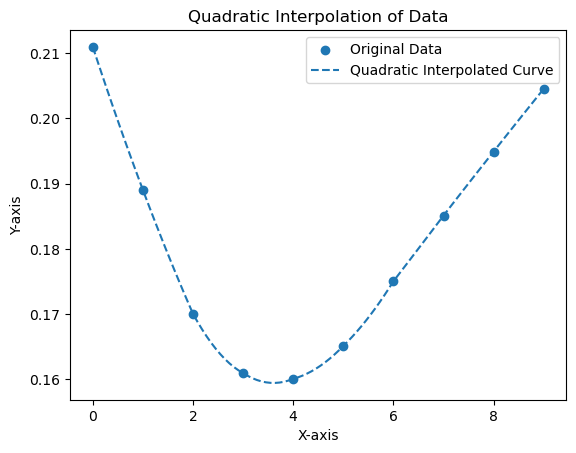

In [6]:
#quadratic interp for better smoothing of the curve

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []

    for x in x_interpolated:
        # Find the segment in which x falls
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        # Quadratic interpolation formula
        # Solving for coefficients a, b, and c of the quadratic equation y = ax^2 + bx + c
        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)

        # Calculate the interpolated y value
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

# Example data
# Replace 'data.index' and 'data["implied_vol"]' with your actual data
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

# Plotting
plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, y_interpolated, label='Quadratic Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Quadratic Interpolation of Data')
plt.show()

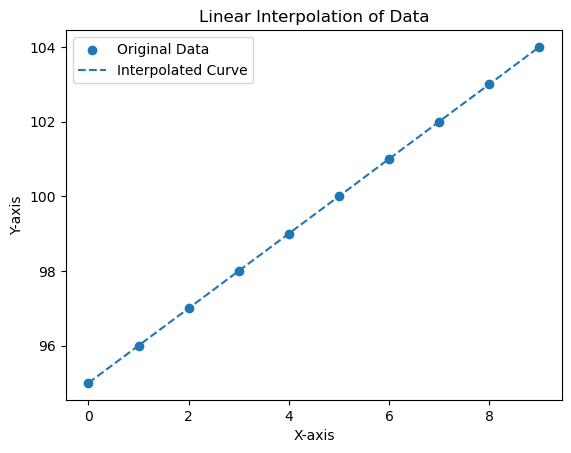

In [7]:
#interpolation of strikes

x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Linear Interpolation of Data')
plt.show()

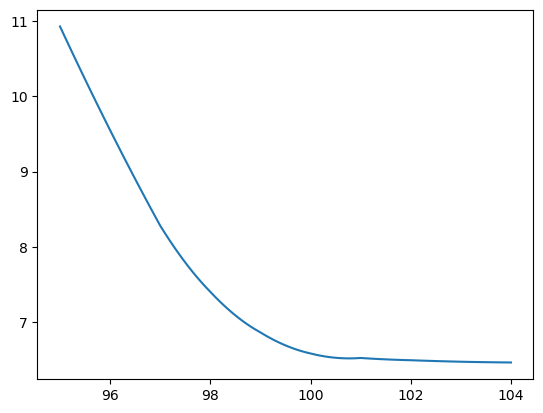

In [8]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

prices=[]

for i,j in zip(strike_interpolated,y_interpolated):
    prices.append(black_scholes_call_price(S,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(df["Strike"],df["Price"])


In [9]:
k=df["Strike"][1]-df["Strike"][0]
df["Breeden"]=0
for i in range(1,len(df)-1):
    derivee_seconde=(df.loc[i+1,"Price"]-2*df.loc[i,"Price"]+df.loc[i-1,"Price"])/(k**2)
    df["Breeden"][i-1]=math.exp(r*(T-t))*derivee_seconde
    

C:\Users\Asus\AppData\Local\Temp\ipykernel_1668\1334426892.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Breeden"][i-1]=math.exp(r*(T-t))*derivee_seconde


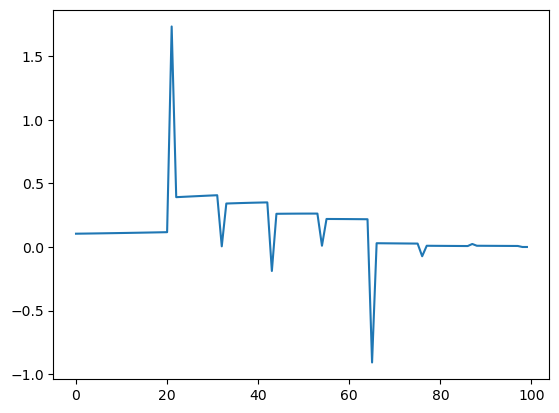

In [10]:
plt.plot(df["Breeden"])

In [11]:
#on calcule breeden pour les valeurs i+1, i-1 et le pas k sera pas 0.1 mais dcp notre pas donc le strike entre i et i-1 

In [12]:
derivee_empirique = (df2[0]-2*df[0]+df1[0])/(k**2)
derivee_empirique

NameError: name 'df2' is not defined

In [ ]:
df2[0]-2*df[0]+df1[0]

In [ ]:
#formule de Breeden-Litzenberger
def Breeden_Litzenberger(data, r, t, St, T):
    return math.exp(r*(T-t))*
    
data["Breeden"] = Breeden_Litzenberger(data, 0, 0, data["prices"], 1)
data["Breeden"]

In [ ]:
gaussian = norm.pdf(data["prices"], data["prices"].mean(), 1)
plt.figure(figsize=(11,4))

plt.plot(data["prices"], gaussian, label="gaussian")
plt.plot(data["prices"], data["Breeden"], label="breeden litzenberger")
plt.grid(True)